# Subtask 1: Binary Classification (Polarization)

## Overview
This notebook implements a complete pipeline for **Subtask 1**, which involves classifying text as either **Polarized** or **Non-Polarized**.

### Key Features:
1.  **Data Loading**: Aggregates data from multiple language CSV files.
2.  **Rigorous Splitting**: Creates a distinct **Held-out Test Set** (20%) that is *never* seen during training or validation.
3.  **Advanced Augmentation**: Uses **NLLB-200** to translate English samples to Amharic (`eng_Latn` -> `amh_Ethi`) to address specific language scarcity.
4.  **Oversampling**: Applies **Random Oversampling** to balance the remaining classes.
5.  **Model**: Uses **XLM-RoBERTa (base)**, a powerful multilingual model.
6.  **Evaluation**: Calculates Macro F1, Accuracy, and generates a detailed Classification Report on the held-out test set.

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoModelForSeq2SeqLM
)
from tqdm import tqdm

In [ ]:
# !unzip /content/dev_phase.zip -d /content/drive/MyDrive/NLP-PROJECT

Archive:  /content/dev_phase.zip
   creating: /content/drive/MyDrive/NLP-PROJECT/subtask1/
   creating: /content/drive/MyDrive/NLP-PROJECT/subtask1/dev/
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/dev/ita.csv  
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/dev/spa.csv  
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/dev/arb.csv  
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/dev/amh.csv  
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/dev/zho.csv  
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/dev/eng.csv  
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/dev/urd.csv  
   creating: /content/drive/MyDrive/NLP-PROJECT/subtask1/train/
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/train/ita.csv  
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/train/spa.csv  
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/train/arb.csv  
  inflating: /content/drive/MyDrive/NLP-PROJECT/subtask1/train/zho.

In [ ]:
# ls -d /content/drive/MyDrive/NLP-PROJECT

/content/drive/MyDrive/NLP-PROJECT/


In [ ]:
import os
df = pd.read_csv("/content/drive/MyDrive/NLP-PROJECT/subtask1/train/eng.csv")

In [ ]:
df

,id,text,polarization
0,en_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,en_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,en_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,en_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,en_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0
...,...,...,...
2671,en_360f4bb42216721ef68725794ba58e04,truly amazing that you can voice your fullthro...,1
2672,en_fb5cbc3b5af39fd8bd9f25b1e96c1638,us nationalism gives cult ngl,1
2673,en_d27003500904e1949c676544d103b25e,"yes i know 4 nations is still going on, howeve...",1
2674,en_0e49858a27536c93bd29e5c00bbfe5e3,zelensky sign up with putin!,1


In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/NLP-PROJECT/subtask1/train/deu.csv")

In [ ]:
df2

,id,text,polarization
0,deu_fa07b0533db91281c049fb722ca121d7,Natürlich bin ich linksgrün - ich habe Herz u ...,0
1,deu_10e753b5d49374d2de1f68dfc1e2d249,"Schuld sind Habeck, die grünen und diese link...",1
2,deu_61be00002367a33400dade564edccc59,Vielleicht ist da ja tatsächlich was dran. Höc...,1
3,deu_d28b20af64d590134448fcdbfbb0f7dd,So. Noch schnell alle linksgrün versifften Dem...,1
4,deu_005fc728be211eae1c308a0fc20d73df,"Ich drücke der Störchin die Daumen, Berlin ist...",1
...,...,...,...
3175,deu_71dc6fdc0c1b30838e729faad51af8e8,"Wird man als Griechin nicht enterbt, wenn man ...",1
3176,deu_78024eeb5743f83e2e78850c907f888c,"Aber weit mehr Italiener als Türken ,die hatte...",1
3177,deu_1d216a97883db35979e64f9e65ddaef1,"Seltsam, Röntgen zur Altersbestimmung bei Asyl...",0
3178,deu_43149792ce872569435304e28c318664,Bei der FPÖ ist keinerlei Art von Flüchtling w...,1


## 1. Configuration and Data Loading
Define your data paths here. If using Google Colab, ensure your Drive is mounted.
## 2. Data Splitting (Train / Validation / Held-out Test)
We perform a **stratified split** to ensure the class distribution is preserved across all sets.
*   **Held-out Test Set (20%)**: Used ONLY for final evaluation.
*   **Training Set (64%)**: Used to train the model.
*   **Validation Set (16%)**: Used for hyperparameter tuning and early stopping.

In [ ]:
import pandas as pd
import glob
import os

# 1. DEFINE YOUR DATA FOLDER PATH
#    !!!! IMPORTANT: Change this to your folder's path !!!!
data_folder = "/content/drive/MyDrive/NLP-PROJECT/subtask1/train"

# 2. Find all .csv files
#    This is updated to look for .csv
file_paths = glob.glob(os.path.join(data_folder, "*.csv"))

# 3. List to hold individual DataFrames
all_dataframes = []

print(f"Found {len(file_paths)} .csv files. Processing...")

# 4. Loop, load, and tag each file
for file_path in file_paths:
    try:
        # --- THIS IS THE KEY CHANGE ---
        df = pd.read_csv(
            file_path,
            sep=',',         # <-- CHANGED from '\t' to ','
            header=0,        # 0 if first row is header, None if no header
            names=['text', 'polarization'] # Uncomment this if you have no header
        )

        # Get language from filename (e.g., "language_data/english.csv" -> "english")
        file_name = os.path.basename(file_path)
        language = os.path.splitext(file_name)[0]

        # Add the 'language' column
        df['language'] = language

        all_dataframes.append(df)
        print(f"Successfully loaded and tagged '{file_name}' ({len(df)} rows)")

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        print("Please check file format (separator, header, etc.)")

# 5. Concatenate all DataFrames into one
if all_dataframes:
    master_df = pd.concat(all_dataframes, ignore_index=True)
    print("\n--- Successfully combined all files ---")

    print(f"Total rows before shuffling: {len(master_df)}")

    # 6. SHUFFLE (RANDOMIZE) THE ENTIRE DATASET
    #    frac=1 means 100% of the data, random_state for reproducible shuffle
    master_df = master_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\n--- Successfully shuffled the dataset ---")

    # 7. Check the final dataset
    print(f"Total rows after shuffling: {len(master_df)}")
    print("Top 5 rows (after shuffling):")
    print(master_df.head())

    print("\nFinal DataFrame Info:")
    master_df.info()

    print("\nLabel distribution:")
    print(master_df['polarization'].value_counts(normalize=True))

    print("\nLanguage distribution:")
    print(master_df['language'].value_counts())

    # 8. Save the final, shuffled file
    output_filename = "combined_shuffled_dataset.csv"
    master_df.to_csv(output_filename, index=False)

    print(f"\nSuccessfully saved combined and shuffled data to '{output_filename}'")

else:
    print("No data was loaded. Please check your 'data_folder' path.")

Found 9 .csv files. Processing...
Successfully loaded and tagged 'ita.csv' (3334 rows)
Successfully loaded and tagged 'zho.csv' (4280 rows)
Successfully loaded and tagged 'urd.csv' (2849 rows)
Successfully loaded and tagged 'amh.csv' (3332 rows)
Successfully loaded and tagged 'arb.csv' (3380 rows)
Successfully loaded and tagged 'eng.csv' (2676 rows)
Successfully loaded and tagged 'spa.csv' (3305 rows)
Successfully loaded and tagged 'deu.csv' (3180 rows)
Successfully loaded and tagged 'hau.csv' (3651 rows)

--- Successfully combined all files ---
Total rows before shuffling: 29987

--- Successfully shuffled the dataset ---
Total rows after shuffling: 29987
Top 5 rows (after shuffling):
                                                text  polarization language
0              this woman is real "bamagujiya" ##url             0      hau
1                呃，哈尔滨和贵阳我都去过，也都打过车，颇有“直把杭州作汴州”的感觉……             0      zho
2                       @USER ሰሞኑን አስቀው ሊጨርሱን ተነስተዋል             0      amh
3 

## 3. Translation Augmentation & Oversampling
This section implements the advanced augmentation strategy:
1.  **Translation Augmentation**: We use **NLLB-200** to translate English samples into Amharic (`amh_Ethi`) to balance the language distribution.
2.  **Random Oversampling**: After translation, we apply standard Random Oversampling to ensure all classes are perfectly balanced.

In [ ]:
data_folder = "/content/drive/MyDrive/NLP-PROJECT/subtask1/train"
output_filename = "combined_TRANSLATED_dataset.csv"

# --- 2. CONFIGURATION ---
# Language mapping for NLLB model
# 'eng_Latn' is English, 'amh_Ethi' is Amharic
SRC_LANG = "eng_Latn"
TGT_LANG = "amh_Ethi"
TARGET_LANG_CODE = "amh" # The code used in your csv files

# --- 3. LOAD MODEL (NLLB-200) ---
print("Loading Translation Model (NLLB-200)...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "facebook/nllb-200-distilled-600M"

try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    print(f"Model loaded on {device}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure you installed transformers: !pip install transformers sentencepiece accelerate")
    exit()

def translate_texts(texts, src_lang, tgt_lang, batch_size=32):
    """Translates a list of texts using the loaded model."""
    translated_texts = []

    # FIX 1: Set source language explicitly so tokenizer knows how to start
    tokenizer.src_lang = src_lang

    for i in tqdm(range(0, len(texts), batch_size), desc="Translating batches"):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        # FIX 2: Use 'convert_tokens_to_ids' instead of 'lang_code_to_id'
        # NllbTokenizerFast uses this method to find the ID for 'amh_Ethi'
        forced_bos_token_id = tokenizer.convert_tokens_to_ids(tgt_lang)

        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                forced_bos_token_id=forced_bos_token_id,
                max_length=128
            )

        batch_translations = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        translated_texts.extend(batch_translations)

    return translated_texts

# --- 4. LOAD DATA ---
file_paths = glob.glob(os.path.join(data_folder, "*.csv"))
all_dataframes = []

print(f"\nFound {len(file_paths)} .csv files. Loading...")

for file_path in file_paths:
    try:
        df = pd.read_csv(file_path, sep=',', header=0)
        df = df.rename(columns={'polarization': 'label'})

        if 'label' not in df.columns: continue

        file_name = os.path.basename(file_path)
        language = os.path.splitext(file_name)[0]
        df['language'] = language

        # Clean labels
        df = df[df['label'].astype(str).isin(['0', '1', '0.0', '1.0'])]
        df['label'] = df['label'].astype(float).astype(int)

        all_dataframes.append(df)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

if not all_dataframes: exit()

master_df = pd.concat(all_dataframes, ignore_index=True)
print("\nOriginal Distribution:")
print(master_df['language'].value_counts())

# --- 5. AUGMENTATION STRATEGY ---
# Identify target size
max_size = master_df['language'].value_counts().max()
print(f"\nTarget size per language: {max_size}")

# Isolate English Data (Source for translation)
english_df = master_df[master_df['language'] == 'eng']
english_texts = english_df['text'].tolist()
english_labels = english_df['label'].tolist()

# Isolate Amharic Data (Target for augmentation)
amharic_count = len(master_df[master_df['language'] == TARGET_LANG_CODE])
rows_needed = max_size - amharic_count

if rows_needed > 0:
    print(f"\nTranslating {rows_needed} English rows to Amharic...")

    # Sample English rows to translate
    # We sample with replacement if we need more rows than we have English data
    sample_source = english_df.sample(n=rows_needed, replace=(rows_needed > len(english_df)), random_state=42)
    texts_to_translate = sample_source['text'].tolist()
    labels_to_keep = sample_source['label'].tolist() # Keep the original labels!

    # PERFORM TRANSLATION
    translated_texts = translate_texts(texts_to_translate, SRC_LANG, TGT_LANG)

    # Create DataFrame for new synthetic data
    synthetic_df = pd.DataFrame({
        'text': translated_texts,
        'label': labels_to_keep,
        'language': TARGET_LANG_CODE # Mark as Amharic
    })

    # Add to master dataframe
    master_df = pd.concat([master_df, synthetic_df], ignore_index=True)
    print("Translation Augmentation Complete!")
else:
    print("Amharic already has enough data. Skipping translation.")

# --- 6. STANDARD BALANCING (For remaining languages) ---
# Now we run the standard oversampler for Urdu, etc., and to catch any remaining gaps
print("\nRunning standard balancing for other languages...")
balanced_dfs = []

for lang in master_df['language'].unique():
    lang_df = master_df[master_df['language'] == lang]

    # Check if we still need rows (e.g. for Urdu)
    current_len = len(lang_df)
    if current_len < max_size:
        oversampled_lang = lang_df.sample(n=max_size, replace=True, random_state=42)
        balanced_dfs.append(oversampled_lang)
    else:
        # If we have too many (e.g. from translation overshoot), sample down, or just keep all?
        # Let's just keep exactly max_size to stay perfectly balanced
        balanced_dfs.append(lang_df.sample(n=max_size, replace=False, random_state=42))

final_df = pd.concat(balanced_dfs, ignore_index=True)

# --- 7. SAVE ---
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)
final_df.to_csv(output_filename, index=False)

print(f"\nSUCCESS! Augmented dataset saved to: {output_filename}")
print("Final Distribution:")
print(final_df['language'].value_counts())

Loading Translation Model (NLLB-200)...


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Model loaded on cuda

Found 9 .csv files. Loading...

Original Distribution:
language
zho    4280
hau    3651
arb    3380
ita    3334
amh    3332
spa    3305
deu    3180
urd    2849
eng    2676
Name: count, dtype: int64

Target size per language: 4280

Translating 948 English rows to Amharic...


Translating batches: 100%|██████████| 30/30 [00:32<00:00,  1.10s/it]


Translation Augmentation Complete!

Running standard balancing for other languages...

SUCCESS! Augmented dataset saved to: combined_TRANSLATED_dataset.csv
Final Distribution:
language
deu    4280
ita    4280
eng    4280
arb    4280
zho    4280
amh    4280
spa    4280
urd    4280
hau    4280
Name: count, dtype: int64


In [ ]:
master_df = pd.read_csv("/content/combined_TRANSLATED_dataset.csv")

In [ ]:
master_df["label"]

,label
0,1
1,1
2,0
3,0
4,1
...,...
38515,1
38516,1
38517,0
38518,1


In [ ]:
master_df = master_df.rename(columns={'label': 'polarization'})

In [ ]:
print(master_df.head())

                                     id  \
0  deu_7cf35bfd6694cf6232f5d20c5b320ec8   
1  ita_59dc04ca85b9fcabbb973e07cc5bae4b   
2   en_bef87e5aed2eb7d8b5c7b636742b9d07   
3   ar_ab1b50e8edfe29316cc58219bab2d218   
4   zh_4346f0d9b2508a27513e5a88e3539a92   

                                                text  polarization language  
0  Nennt sich auch Vergleich, der einer (duh) ver...             1      deu  
1        purtroppo a me i gay stanno tutti sul cazzo             1      ita  
2      Got an ice cream machine, made some ice cream             0      eng  
3  كورة عالطاير  مع اشرف حسين\nالمستقبل الرياضي ب...             0      arb  
4                          又要属猴又要男孩，要求怎么这么高。汗(\\" )汗             1      zho  


In [ ]:
print(master_df['polarization'].value_counts(normalize=True))

polarization
0    0.535981
1    0.464019
Name: proportion, dtype: float64


In [ ]:


master_df['polarization'] = master_df['polarization'].astype(int)
master_df['text'] = master_df['text'].astype(str)

# Use 'text' and 'label' columns
X = master_df['text']
y = master_df['polarization']

# 1. First Split: Separate out the Training set (80%)
# We allocate 20% to a temporary set that will become Val and Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2. Second Split: Split the remaining 20% equally (50/50)
# This results in 10% Validation and 10% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Training data:   {len(X_train)} samples")
print(f"Validation data: {len(X_val)} samples")
print(f"Held-out Test:   {len(X_test)} samples")
print("-" * 30)
print("Data split complete.")

Training data:   30816 samples
Validation data: 3852 samples
Held-out Test:   3852 samples
------------------------------
Data split complete.


## 4. Tokenization and Dataset Class
We define a custom PyTorch `Dataset` class to handle the tokenized inputs.

In [ ]:
MODEL_NAME = "xlm-roberta-base"
print(f"Loading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Create a custom PyTorch Dataset class
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Build the item dictionary from tokenized encodings
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

print("Tokenizer loaded and Dataset class defined.")


Loading tokenizer for xlm-roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizer loaded and Dataset class defined.


In [ ]:
print("Tokenizing datasets...")
# Note: Using .tolist() is much faster than iterating
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)

# Create the dataset objects
train_dataset = PolarizationDataset(train_encodings, y_train)
val_dataset = PolarizationDataset(val_encodings, y_val)
test_dataset = PolarizationDataset(test_encodings, y_test)

print("Tokenization complete. Datasets are ready.")

Tokenizing datasets...
Tokenization complete. Datasets are ready.


## 5. Model Training
We initialize the `XLM-RoBERTa` model for sequence classification and define the training arguments.

In [ ]:
print(f"Loading model {MODEL_NAME} for 2-label classification...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2  # (0=Non-Polarized, 1=Polarized)
)

# --- Define the Evaluation Metric (Macro F1) ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {'macro_f1': macro_f1}

print("Model loaded and metrics function defined.")

Loading model xlm-roberta-base for 2-label classification...


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and metrics function defined.


In [ ]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',          # Directory to save model checkpoints
    num_train_epochs=5,
    learning_rate=2e-5, # Total number of training epochs (3 is a good start)
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=32,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=100,               # Log every X updates
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save checkpoint at the end of each epoch
    load_best_model_at_end=True,     # Load the best model at the end
    metric_for_best_model="macro_f1",# The metric to use to find the "best" model
    greater_is_better=True,          # For F1, higher is better
    report_to="none"                 # Disable extra logging (like W&B)
)

print("Training arguments set.")

Training arguments set.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# --- Start Training! ---
print("Starting model training...")
trainer.train()

print("Training finished.")
print("-" * 30)

Starting model training...


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# In a new cell after training
print("Running heldout set predictions...")
test_predictions = trainer.predict(test_dataset)
final_test_preds = test_predictions.predictions.argmax(axis=1)

# Create a new DataFrame to analyze
analysis_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'prediction': final_test_preds
})

# Find the language for each validation text
# (This merge requires your original_df to have 'text' and 'language' columns)
original_df = pd.read_csv("combined_shuffled_dataset.csv")
analysis_df = pd.merge(analysis_df, original_df[['text', 'language']], on='text', how='left').drop_duplicates()

# --- Now, the cool part ---
print("\n--- Per-Language F1 Score ---")
from sklearn.metrics import f1_score

# Group by language and calculate F1
per_lang_f1 = analysis_df.groupby('language').apply(
    lambda x: f1_score(x['true_label'], x['prediction'], average='macro')
)
print(per_lang_f1.sort_values())

# --- Overall Macro F1 ---
overall_f1 = f1_score(analysis_df['true_label'], analysis_df['prediction'], average='macro')
print(f"\n--- Overall Macro F1 Score: {overall_f1:.4f} ---")

Running heldout set predictions...



--- Per-Language F1 Score ---
language
amh    0.706380
zho    0.846899
ita    0.870717
hau    0.874911
deu    0.883187
spa    0.911010
arb    0.911092
urd    0.918277
eng    0.936369
dtype: float64

--- Overall Macro F1 Score: 0.8916 ---


/tmp/ipython-input-2795132153.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_lang_f1 = analysis_df.groupby('language').apply(


## 7. Error Analysis
Inspect some failure cases to understand where the model struggles.

Generating predictions on Validation Set...



--- 🌍 Per-Language Performance (Macro F1) ---
  Language  Macro F1  Count
7      amh  0.750741    413
3      zho  0.846899    395
6      ita  0.866180    415
0      hau  0.877683    431
1      deu  0.880143    448
4      arb  0.904376    452
5      spa  0.909491    398
2      urd  0.923051    462
8      eng  0.941555    438


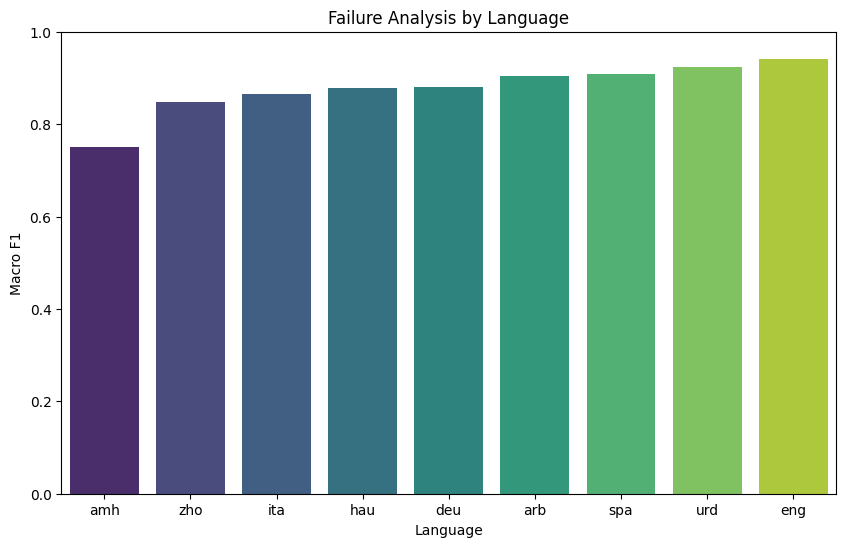


--- 🔄 Binary Confusion Matrix ---


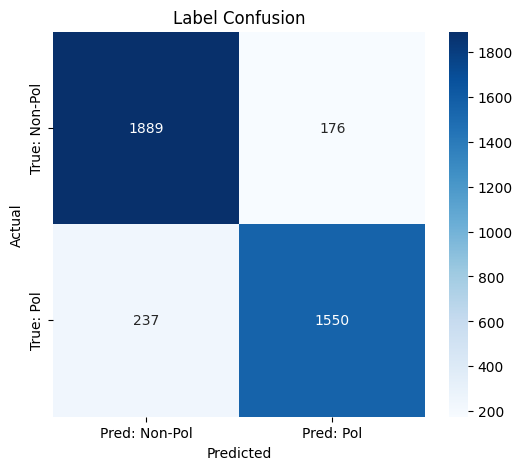


Found 176 False Positives (Over-sensitivity candidates)
Found 237 False Negatives (Subtlety candidates)

Saved 'error_analysis_FALSE_POSITIVES.csv' and 'error_analysis_FALSE_NEGATIVES.csv'.
Open these files to manually inspect text for Sarcasm or Context failures.

--- 👀 Example False Positive (Over-sensitivity?) ---
[spa] judio es cuando gay, las pendejadas que se encuentran en internet

--- 👀 Example False Negative (Subtle Polarization?) ---
[zho] 我家安徽农村的，养猪确实污染水，污染空气，离养猪场几百米就能闻到味道，真的臭


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# --- 1. PREPARE THE DATA ---
print("Generating predictions on Validation Set...")
# Get raw predictions from the trainer
pred_output = trainer.predict(test_dataset)
y_preds = pred_output.predictions.argmax(-1)

# Reconstruct the Validation DataFrame with Metadata
# We use X_val.index to pull the original 'language' and text from master_df
analysis_df = master_df.loc[X_test.index].copy()
analysis_df['predicted_label'] = y_preds
analysis_df['true_label'] = y_test

# Define mappings for readability
label_map = {0: 'Non-Polarized', 1: 'Polarized'}
analysis_df['predicted_str'] = analysis_df['predicted_label'].map(label_map)
analysis_df['true_str'] = analysis_df['true_label'].map(label_map)

# --- 2. LANGUAGE-SPECIFIC FAILURE (Quantitative) ---
print("\n--- 🌍 Per-Language Performance (Macro F1) ---")
lang_metrics = []

for lang in analysis_df['language'].unique():
    lang_df = analysis_df[analysis_df['language'] == lang]
    f1 = f1_score(lang_df['true_label'], lang_df['predicted_label'], average='macro')
    count = len(lang_df)
    lang_metrics.append({'Language': lang, 'Macro F1': f1, 'Count': count})

metrics_df = pd.DataFrame(lang_metrics).sort_values(by='Macro F1')
print(metrics_df)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Language', y='Macro F1', hue='Language', palette='viridis', legend=False)
plt.title("Failure Analysis by Language")
plt.ylim(0, 1.0)
plt.show()


# --- 3. LABEL CONFUSION (Confusion Matrix) ---
print("\n--- 🔄 Binary Confusion Matrix ---")
cm = confusion_matrix(analysis_df['true_label'], analysis_df['predicted_label'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Non-Pol', 'Pred: Pol'],
            yticklabels=['True: Non-Pol', 'True: Pol'])
plt.title("Label Confusion")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# --- 4. EXTRACT FALSE POSITIVES & NEGATIVES (Qualitative) ---
# False Positives: Model said "Polarized" (1), but it was "Non-Polarized" (0)
# These check for "Over-sensitivity"
fp_df = analysis_df[(analysis_df['predicted_label'] == 1) & (analysis_df['true_label'] == 0)]

# False Negatives: Model said "Non-Polarized" (0), but it was "Polarized" (1)
# These check for "Subtlety / Missed Context"
fn_df = analysis_df[(analysis_df['predicted_label'] == 0) & (analysis_df['true_label'] == 1)]

print(f"\nFound {len(fp_df)} False Positives (Over-sensitivity candidates)")
print(f"Found {len(fn_df)} False Negatives (Subtlety candidates)")

# Save to CSV for manual review
fp_df[['language', 'text', 'true_str', 'predicted_str']].to_csv("error_analysis_FALSE_POSITIVES.csv", index=False)
fn_df[['language', 'text', 'true_str', 'predicted_str']].to_csv("error_analysis_FALSE_NEGATIVES.csv", index=False)

print("\nSaved 'error_analysis_FALSE_POSITIVES.csv' and 'error_analysis_FALSE_NEGATIVES.csv'.")
print("Open these files to manually inspect text for Sarcasm or Context failures.")

# --- 5. PEEK AT EXAMPLES ---
print("\n--- 👀 Example False Positive (Over-sensitivity?) ---")
if not fp_df.empty:
    row = fp_df.iloc[0]
    print(f"[{row['language']}] {row['text']}")

print("\n--- 👀 Example False Negative (Subtle Polarization?) ---")
if not fn_df.empty:
    row = fn_df.iloc[0]
    print(f"[{row['language']}] {row['text']}")

## 7. Bootstrapping

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoModelForSequenceClassification, Trainer
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=32,
    report_to="none"  # Turn off wandb/logging for this quick evaluation
)
# --- 1. CONFIGURATION ---
# REPLACE THIS with the path to the specific checkpoint you want to evaluate
CHECKPOINT_PATH = "/content/drive/MyDrive/NLP-PROJECT/subtask1/checkpoint-9630/results/checkpoint-9630"

# --- 2. DEFINE BOOTSTRAPPING FUNCTION ---
def bootstrap_metric(y_true, y_pred, metric_func, n_bootstraps=1000, ci=95, average=None):
    """
    Calculates the confidence interval for a given metric using bootstrapping.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rng = np.random.RandomState(42)
    bootstrapped_scores = []

    print(f"Bootstrapping {metric_func.__name__}...")

    for i in range(n_bootstraps):
        # Resample indices with replacement
        indices = rng.randint(0, len(y_true), len(y_true))

        if average:
            score = metric_func(y_true[indices], y_pred[indices], average=average)
        else:
            score = metric_func(y_true[indices], y_pred[indices])

        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)

    # Calculate lower and upper bounds
    lower_bound = (100 - ci) / 2
    upper_bound = 100 - lower_bound

    ci_lower = np.percentile(sorted_scores, lower_bound)
    ci_upper = np.percentile(sorted_scores, upper_bound)
    mean_score = np.mean(sorted_scores)

    return ci_lower, ci_upper, mean_score

# --- 3. LOAD CHECKPOINT & PREDICT ---
print(f"Loading model from: {CHECKPOINT_PATH}...")
model = AutoModelForSequenceClassification.from_pretrained(
    CHECKPOINT_PATH,
    num_labels=2
)

# Initialize Trainer (using your existing training_args and val_dataset)
trainer = Trainer(
    model=model,
    args=training_args,        # Assumes 'training_args' is already defined in your notebook
    eval_dataset=test_dataset,  # Assumes 'val_dataset' is already defined
    compute_metrics=compute_metrics
)

print("Running predictions on validation set...")
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

# --- 4. CALCULATE & PRINT RESULTS ---
print(f"\nResults for {CHECKPOINT_PATH}:")
print("-" * 30)

# Accuracy
acc_low, acc_high, acc_mean = bootstrap_metric(y_true, y_pred, accuracy_score)
print(f"Accuracy: {acc_mean:.4f}  [95% CI: {acc_low:.4f} - {acc_high:.4f}]")

# Macro F1
f1_low, f1_high, f1_mean = bootstrap_metric(y_true, y_pred, f1_score, average='macro')
print(f"Macro F1: {f1_mean:.4f}  [95% CI: {f1_low:.4f} - {f1_high:.4f}]")

Loading model from: /content/drive/MyDrive/NLP-PROJECT/subtask1/checkpoint-9630/results/checkpoint-9630...
Running predictions on validation set...



Results for /content/drive/MyDrive/NLP-PROJECT/subtask1/checkpoint-9630/results/checkpoint-9630:
------------------------------
Bootstrapping accuracy_score...
Accuracy: 0.8965  [95% CI: 0.8866 - 0.9058]
Bootstrapping f1_score...
Macro F1: 0.8957  [95% CI: 0.8858 - 0.9053]
